# Dataset analysis & preprocessing exploration
by Domrachev Ivan, B20-RO-01

In [3]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import wordcloud
from PIL import Image
pd.options.display.max_colwidth = 150

from collections import Counter
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import gensim
from nltk.corpus import stopwords
import pyLDAvis
import pyLDAvis.gensim

import sys
sys.path.append("../src/visualization")
from data_visualization import plot_histograms, visualize_via_wordcloud

# Raw data investigation

In [5]:
raw_df = pd.read_csv('../data/raw/filtered.tsv', sep='\t', index_col=0)

raw_df.head()

,reference,translation,similarity,lenght_diff,ref_tox,trn_tox
0,"If Alkar is flooding her with psychic waste, that explains the high level of neurotransmitters.","if Alkar floods her with her mental waste, it would explain the high levels of neurotransmitter.",0.785171,0.010309,0.014195,0.981983
1,Now you're getting nasty.,you're becoming disgusting.,0.749687,0.071429,0.065473,0.999039
2,"Well, we could spare your life, for one.","well, we can spare your life.",0.919051,0.268293,0.213313,0.985068
3,"Ah! Monkey, you've got to snap out of it.","monkey, you have to wake up.",0.664333,0.309524,0.053362,0.994215
4,I've got orders to put her down.,I have orders to kill her.,0.726639,0.181818,0.009402,0.999348


The dataset contains the following data:
1. Reference phrase
2. Paraphrased version
3. Cosine similarity of two texts
4. Difference in lengths
5. Reference text toxicity
6. Paraphrased version toxicity

According to the original [data-mining notebook](https://github.com/s-nlp/detox/blob/main/emnlp2021/style_transfer/mining_parallel_corpus/paranmt_mining.ipynb), the data-mining process looked like this:
1. The base dataset is [ParaNMT-50M](https://www.cs.cmu.edu/~jwieting/wieting2017Millions.pdf), which is a English-English paraphrasing dataset. 
2. Then, the dataset was filtered w.r.t. cosine similarity (it should be in bounds of $[0.6; 0.95]$) and length difference (less than $0.4$).
3. Then they estimated toxicity of the text using [fine-tuned RoBERTa](https://huggingface.co/s-nlp/roberta_toxicity_classifier_v1) for both initial text and paraphrased version and kept only those entries with difference in toxicity greater than 50%

Let's validate that by analysing toxicity levels, cosinse similarities, and length differences:

In [6]:
plot_histograms(raw_df, save=True, fname_hist='image/raw_histogram.png');
plot_distance(raw_df, save=True, fname_hist='image/length_diff.png');
plot_length_distributions(raw_df, save=True, fname_hist='image/length_distr.png');

<Figure size 800x600 with 0 Axes>

![](image/raw_histogram.png)
![](image/length_diff.png)

The graphs show that the filters from the paper are presented in the given data as well. Let's also visualize the word clouds: 

In [7]:
raw_img = visualize_via_wordcloud(raw_df['reference'], raw_df['translation'], save=True, fname='raw_wordcloud.png')

![](image/raw_wordcloud.png)

# Data preprocessing

The first problem, which is very easy to notice is that translation is not guaranteed to be less toxic than paraphrased version, f.e:

In [3]:
raw_df[(raw_df['ref_tox'] < 0.2) & (raw_df['trn_tox'] > 0.8)].head()

,reference,translation,similarity,lenght_diff,ref_tox,trn_tox
0,"If Alkar is flooding her with psychic waste, that explains the high level of neurotransmitters.","if Alkar floods her with her mental waste, it would explain the high levels of neurotransmitter.",0.785171,0.010309,0.014195,0.981983
1,Now you're getting nasty.,you're becoming disgusting.,0.749687,0.071429,0.065473,0.999039
3,"Ah! Monkey, you've got to snap out of it.","monkey, you have to wake up.",0.664333,0.309524,0.053362,0.994215
4,I've got orders to put her down.,I have orders to kill her.,0.726639,0.181818,0.009402,0.999348
8,"Briggs, what the hell's happening?","Briggs, what the hell is going on?",0.920373,0.000000,0.159096,0.841071


To elimitate this, let's swap all the entries such that the reference toxicity would be always bigger:

In [4]:
preprocessed_df = raw_df.copy(deep=True)
cond = (raw_df["ref_tox"] < raw_df["trn_tox"])
preprocessed_df.loc[cond, ['reference', 'translation', 'ref_tox', 'trn_tox']] = (
    preprocessed_df.loc[cond, ['translation', 'reference', 'trn_tox', 'ref_tox']].values)

assert (preprocessed_df["ref_tox"] < preprocessed_df["trn_tox"]).sum() == 0

Now, let's examine some entries with intermediate resulting toxicity:

In [5]:
preprocessed_df[preprocessed_df['trn_tox'] > 0.3].head()

,reference,translation,similarity,lenght_diff,ref_tox,trn_tox
64,Then nolan's gonna be destroyed.,Nolan will destroy it.,0.797925,0.303030,0.974547,0.303680
66,I hope you freeze the piss.,I hope your pee-pee freeze up.,0.808864,0.096774,0.979714,0.476306
98,"""don't even look back, you... you pussy.""","'Don't you even turn around, you . . . you turd.' Jules went out.",0.616171,0.363636,0.999517,0.311901
121,There's enough people here to say that within two months at least one of you will die.,there's a lot of people to say that within 2 months at least one of you will die.,0.905752,0.057471,0.980124,0.446940
164,what do I do if you leave to be killed?,How do you expect me to behave when you go off and get killed?,0.649492,0.365079,0.944440,0.432443


and compare them to more extreme paraphrasing results:

In [6]:
preprocessed_df[preprocessed_df['trn_tox'] < 0.01].head()

,reference,translation,similarity,lenght_diff,ref_tox,trn_tox
4,I have orders to kill her.,I've got orders to put her down.,0.726639,0.181818,0.999348,0.009402
6,"They're all laughing at us, so we'll kick your ass.",they're laughing at us. We'll show you.,0.618866,0.230769,0.999492,0.000131
10,you'd probably want me to buy you some chocolates and flowers... and whispered some pretty rubbish.,I suppose you want me to buy you flowers and chocolates and whisper sweet nothings.,0.800661,0.160000,0.980341,0.000078
12,I'll freeze him!,Freezing him.,0.775646,0.176471,0.573710,0.007186
13,"Come on, Cal, leave that shit alone.","come on, Cal, put it down.",0.660481,0.270270,0.999637,0.000279


From the imperical evaluation, one could see that the lowest translational toxicity are generally much more adequate paraphrasing examples than for the higher values. Since we are not able to learn on extended time period, it's possible to shrink the amount of the data and leave only the best-qualiry results:

In [ ]:
print(f"Current length of the dataset: {len(preprocessed_df['trn_tox'])}")
preprocessed_df = preprocessed_df[preprocessed_df["trn_tox"] < 0.01]
print(f"Current length of the dataset: {len(preprocessed_df['trn_tox'])}")

Current length of the dataset: 577777
Current length of the dataset: 355026


However, the fine-tuning of the models showed, that excluding the non-toxic references from the dataset would dramatically speed up convergence. 

For example, the first step for T5 model showed the following losses at the first and second epoches:
1. Reference toxicity -- any: 1.993625 -> 1.933838
2. Reference toxicity > 0.99: 2.054661 -> 2.041412

Therefore, let's additionally leave the most toxic reference comments:

In [ ]:
print(f"Current length of the dataset: {len(preprocessed_df['trn_tox'])}")
preprocessed_df = preprocessed_df[preprocessed_df["ref_tox"] > 0.99]
print(f"Current length of the dataset: {len(preprocessed_df['trn_tox'])}")

Current length of the dataset: 577777
Current length of the dataset: 355026


Let's visualize the new dataset distributions and pointclouds:

In [ ]:
plot_histograms(preprocessed_df, save=True, fname_hist='image/preproc_histogram.png')

![](image/preproc_histogram.png)

Note, that the distribution of reference toxicity hasn't significantly changed. Hence, it retained most of representability.

## Advanced data visualisation

First, let's visualize word frequencies:

In [26]:
nltk.download('stopwords')
import string 

stop = set(stopwords.words('english'))

ref_tokenized = preprocessed_df['reference'].str.replace('[^\w\s]','', regex=True).apply(str.lower).apply(word_tokenize).to_list()
ref_corpus = [word for sent in ref_tokenized for word in sent if word not in stop]

tsn_tokenized = preprocessed_df['translation'].str.replace('[^\w\s]','', regex=True).apply(str.lower).apply(word_tokenize).to_list()
tsn_corpus = [word for sent in tsn_tokenized for word in sent if word not in stop]

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dom_iva/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
ref_counter = Counter(ref_corpus)
tsn_counter = Counter(tsn_corpus)
ref_most_common = ref_counter.most_common(40)

words, ref_counts, tsn_counts = [], [], []
for word, count in ref_most_common[:20]:
    words.append(word)
    ref_counts.append(count)
    tsn_counts.append(tsn_counter[word])

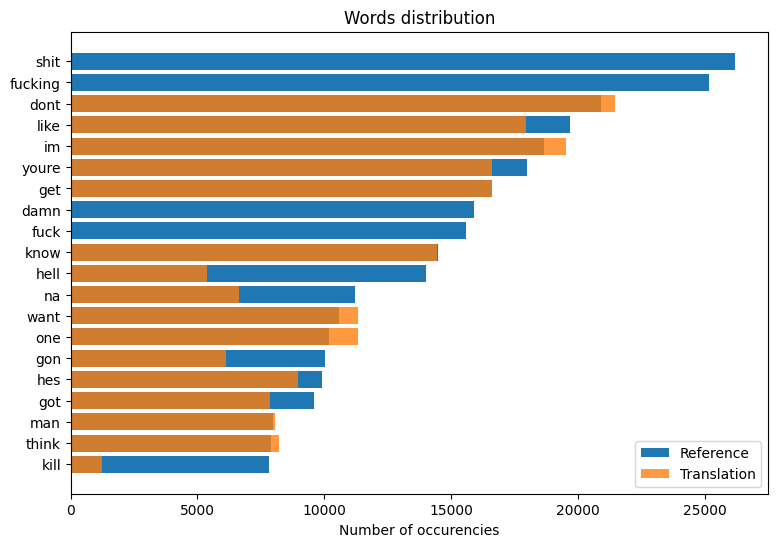

In [32]:
plt.figure(figsize=(9, 6))
plt.barh(y=words[::-1], width=ref_counts[::-1], label='Reference')
plt.barh(y=words[::-1], width=tsn_counts[::-1], label='Translation', alpha=0.8)
plt.title('Words distribution')
plt.xlabel('Number of occurencies')
plt.legend()
plt.savefig('image/word_frequencies.png')

Note that the translated dataset contains much less curses and offensive words. This might suggest that the dataset was preprocessed pretty well.

Now, let's try to perform topic modelling, i.e. use unsupervised learning to separate the sentences on the different topics.

In [44]:
topic_modelling_corpus = [[word for word in sent if word not in stop] for sent in ref_tokenized[:20000]]

In [45]:
dic = gensim.corpora.Dictionary(topic_modelling_corpus)
bow_corpus = [dic.doc2bow(doc) for doc in topic_modelling_corpus]

In [48]:
def plot_lda_vis(lda_model, bow_corpus, dic):
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
    return vis


lda_model = gensim.models.LdaMulticore(bow_corpus,
                                        num_topics = 8,
                                        id2word = dic,
                                        passes = 10,
                                        workers = 8)
lda_model.show_topics()

[(0,
  '0.036*"hell" + 0.022*"want" + 0.013*"look" + 0.013*"dont" + 0.012*"shoot" + 0.012*"like" + 0.009*"crap" + 0.009*"one" + 0.008*"old" + 0.007*"fucking"'),
 (1,
  '0.026*"shit" + 0.022*"know" + 0.021*"like" + 0.020*"dont" + 0.016*"youre" + 0.014*"crazy" + 0.014*"give" + 0.014*"fucking" + 0.009*"hes" + 0.008*"na"'),
 (2,
  '0.034*"fucking" + 0.030*"damn" + 0.022*"hes" + 0.018*"like" + 0.015*"die" + 0.012*"youre" + 0.011*"kill" + 0.008*"us" + 0.007*"im" + 0.007*"fool"'),
 (3,
  '0.024*"shit" + 0.021*"oh" + 0.016*"got" + 0.016*"damn" + 0.014*"fucking" + 0.011*"thats" + 0.010*"car" + 0.010*"would" + 0.010*"god" + 0.009*"ill"'),
 (4,
  '0.053*"fuck" + 0.041*"get" + 0.025*"shit" + 0.017*"im" + 0.012*"youre" + 0.010*"go" + 0.008*"hell" + 0.007*"dont" + 0.006*"someone" + 0.006*"going"'),
 (5,
  '0.021*"fucking" + 0.018*"think" + 0.017*"stupid" + 0.015*"youre" + 0.015*"dont" + 0.011*"shit" + 0.010*"im" + 0.010*"know" + 0.009*"balls" + 0.008*"hell"'),
 (6,
  '0.012*"killed" + 0.011*"man" + 

In [49]:
plot_lda_vis(lda_model, bow_corpus, dic)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.033247  0.040691       1        1  15.642199
1     -0.010461  0.100365       2        1  13.118245
0     -0.009170 -0.071510       3        1  12.909794
4     -0.172691 -0.002528       4        1  12.804720
2      0.150336 -0.010417       5        1  12.744792
3      0.068879  0.013330       6        1  11.131268
5      0.011541  0.095380       7        1  10.929592
6     -0.005187 -0.165313       8        1  10.719389, topic_info=     Term        Freq        Total Category  logprob  loglift
72   fuck  795.000000   795.000000  Default  30.0000  30.0000
148  hell  683.000000   683.000000  Default  29.0000  29.0000
177   get  834.000000   834.000000  Default  28.0000  28.0000
160    na  553.000000   553.000000  Default  27.0000  27.0000
129  damn  820.000000   820.000000  Default  26.0000  26.0000
..    ...         ...          ...      ...      ...      ...
0    kill   50.920881   380.730090   Topic8  -5.3621   0.2213
104   got   41.308780   434.123580   Topic8  -5.5713  -0.1191
72   fuck   46.454974   795.358457   Topic8  -5.4539  -0.6072
23   shit   47.311108  1257.451030   Topic8  -5.4356  -1.0470
77   time   35.969755   291.053186   Topic8  -5.7097   0.1423

[629 rows x 6 columns], token_table=       Topic      Freq   Term
term                         
7571       5  0.877836     25
4008       5  0.939567      6
275        2  0.760140      9
11359      1  0.850534     a4
317        1  0.827858   aint
...      ...       ...    ...
31         4  0.177572  youre
31         5  0.182245  youre
31         6  0.035047  youre
31         7  0.197432  youre
31         8  0.019860  youre

[1594 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 2, 1, 5, 3, 4, 6, 7])

Unfortunately, the author failed to interpret found categories, and does it seems 

Finally, let's analyse the word cloud for the preprocessed dataset:

In [ ]:
raw_img = visualize_via_wordcloud(preprocessed_df['reference'], preprocessed_df['translation'], save=True, fname='raw_wordcloud.png')

![](image/raw_wordcloud.png)

As one could see, the word cloud for the detoxified sentences now contain fewer bad words.

# Saving the result

Now let's save the result as `Dataset` class from HuggingFace and push it to their cloud:

In [9]:
import sys
sys.path.append('../../src/data/')
import make_dataset

In [12]:
dataset = make_dataset.DetoxDataset(
    lazy_init=True
)
hf_dataset = dataset.split_dataset(
    preprocessed_df, 
    load_whole_ds=True, 
    save_arrow=True, 
    fdir = '../../data/interim/'
)

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Saving the dataset (0/1 shards):   0%|          | 0/319523 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/35503 [00:00<?, ? examples/s]

Additionally, you can push resulting dataset to the cloud:

In [13]:
hf_dataset.push_to_hub('domrachev03/toxic_comments_subset')

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Done! Now by running `dataset = datasets.load_dataset('domrachev03/toxic_comments_subset')` anyone could get access to the postprocessed data!